In [1]:
import sys
sys.path.insert(0, '..')
import utils.game_utils as gu

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def get_previous_record(year, week, team, all_games_df):
    records = all_games_df[(all_games_df['year'] == year)
                           & (all_games_df['week'] < week) &
                           (all_games_df['team'] == team)]
    if len(records) < 1:
        return None

    return records[-1:]


def get_all_previous_records(year, week, team, all_games_df):
    records = all_games_df[(all_games_df['year'] == year)
                           & (all_games_df['week'] < week) &
                           (all_games_df['team'] == team)]
    if len(records) < 1:
        return None

    return records

def trim_df(df, fields=None):
    if fields is None:
        fields = [
            'team_wins_before',
            'team_losses_before', 'team_ties_before', 'team_wins_after',
            'team_losses_after', 'team_ties_after', 'team_record_total_before',
            'team_record_total_after', 'team_record_normal_before',
            'team_record_normal_after', 'team_opprec_normal_before',
            'team_opprec_normal_after'
        ]
    out_fields = ['year', 'week', 'team_win', 'team']
    out_fields.extend(fields)
    return df[out_fields]


all_games_df = pd.read_csv('../../data/games/all_games_with_data.csv')


In [10]:
def get_df_with_aggregates(index, all_games_df, side='team'):
    SIDE = side # can be opponent
    OTHER_SIDE = 'opponent' if SIDE == 'team' else 'team'
    WEEK_1_TRN = 0.5
    game_df = all_games_df.iloc[index]
    year = game_df['year']
    week = game_df['week']
    team = game_df[SIDE]
    opp_team = game_df[OTHER_SIDE]

    previous_df = get_previous_record(year, week, team, all_games_df)
    opp_previous_df = get_previous_record(year, week, opp_team, all_games_df)

    wins_before = 0
    losses_before = 0
    ties_before = 0

    wins_after = 0
    losses_after = 0
    ties_after = 0

    # todo: still need to handle these (before and after?)
    record_total_before = 0
    record_total_after = 0
    record_normal_before = 0
    record_normal_after = 0
    opp_strength_before = 0
    opp_strength_after = WEEK_1_TRN  # first week everyone is a 50/50 team
    # accumulated normalized records of all opponents
    opprec_normal_before = 0
    opprec_normal_after = 1.0
    opp_trn = WEEK_1_TRN

    ## INFO FROM THIS GAME
    win = bool(game_df[f'{SIDE}_win'])
    tie = game_df['team_score'] == game_df['opponent_score'] # no need for SIDE, just see if both scores are the same
    loss = win == False and tie == False

    def get_val_or(df, field):
        val = df.iloc[0][field]
        if np.isnan(val):
            return 0
        return val
    def get_normalized(x, min, max):
        return (x-min) / (max-min)
    def get_opprec_normal_after(opp_previous_df, record_normal_after):
        if opp_previous_df is None:
            return 1.0

        pre_week = get_val_or(opp_previous_df, 'week')
        pre_opprec_after = get_val_or(opp_previous_df,
                                      f'{SIDE}_opprec_normal_after')
        pre_trn_after = get_val_or(opp_previous_df,
                                   f'{SIDE}_record_normal_after')

        new_opprec = (pre_opprec_after + pre_trn_after) / 2
        final_new_opprec = (new_opprec + record_normal_after) / 2

        return final_new_opprec
    def get_opp_strength_after(opp_previous_df, opp_strength_before):
        '''
        Opponent Strength is essentially the TRN value
        (record_normal) or the wins/losses of a team.
        We want to accumulate the opp_strength from week to
        week to see how strong all opponents have been.
        '''
        if opp_previous_df is None:
            return 1.0

        opp_prev_trn = get_val_or(opp_previous_df, f'{SIDE}_record_normal_after')
        # normalized (/2)
        return (opp_strength_before + opp_prev_trn) / 2


    ## DATA FROM PREVIOUS GAME
    if previous_df is not None:
        try:
            wins_before = get_val_or(previous_df, f'{SIDE}_wins_after')
            losses_before = get_val_or(previous_df, f'{SIDE}_losses_after')
            ties_before = get_val_or(previous_df, f'{SIDE}_ties_after')
            record_total_before = get_val_or(previous_df,
                                              f'{SIDE}_record_total_after')
            record_normal_before = get_val_or(previous_df,
                                              f'{SIDE}_record_normal_after')
            opprec_normal_before = get_val_or(previous_df,
                                              f'{SIDE}_opprec_normal_after')
            opp_strength_before = get_val_or(previous_df,
                                              f'{SIDE}_opp_strength_after')

            wins_after = wins_before
            losses_after = losses_before
            ties_after = ties_before
            record_total_after = record_total_before
            record_normal_after = record_normal_before
            opprec_normal_after = get_opprec_normal_after(
                opp_previous_df, record_normal_after)

            opp_strength_after = get_opp_strength_after(
                opp_previous_df, opp_strength_before)

            opp_trn = get_val_or(opp_previous_df,
                                 f'{SIDE}_record_normal_after')

        except Exception as e:
            print(e)

    ## CALCULATE NEW DATA (after)
    if win:
        wins_after += 1
    if tie:
        ties_after += 1
    if loss:
        losses_after += 1

    ## CALCULATE RECORD NORMAL
    record_total_after = wins_after - losses_after # eg: +2 or -7 etc.
    record_normal_after = get_normalized(record_total_after, week * -1, week)


    # todo: maybe we should be authoring is_tie as well?

    all_games_df.at[index, [
        f'{SIDE}_wins_before',
        f'{SIDE}_wins_after',
        f'{SIDE}_losses_before',
        f'{SIDE}_losses_after',
        f'{SIDE}_ties_before',
        f'{SIDE}_ties_after',
        f'{SIDE}_record_total_before',
        f'{SIDE}_record_total_after',
        f'{SIDE}_record_normal_before',
        f'{SIDE}_record_normal_after',
        f'{SIDE}_opp_strength_before',
        f'{SIDE}_opp_strength_after',
        f'{SIDE}_opprec_normal_before',
        f'{SIDE}_opprec_normal_after',
        f'{SIDE}_opp_trn',
    ]] = [
        wins_before, wins_after, losses_before, losses_after, ties_before,
        ties_after, record_total_before, record_total_after,
        record_normal_before, record_normal_after, opp_strength_before,
        opp_strength_after, opprec_normal_before, opprec_normal_after, opp_trn
    ]

    return all_games_df.iloc[index]


def get_team_df(team, year, all_df):
    return all_df[(all_df['team'] == team) & (all_df['year'] == year)]
def get_year_df(year, all_df):
    return all_df[all_df['year'] == year]
def get_year_up_to_week_df(year, week, all_df):
    return all_df[(all_df['year'] == year) & (all_df['week'] <= week)]

## - - - - - - - - - - - - - - - - - - - -- - - -- - - - - - - -
## C O N F I G
## - - - - - - - - - - - - - - - - - - - -- - - -- - - - - - - -
YEAR = 2018
UP_TO_WEEK = 16
## ADD NEW COLUMNS TO ALL GAMES AND CREATE NEW ALL_GAMES_PLUS_DF (agp_df)
new_col_df = pd.DataFrame(columns=[
    'team_wins_before', 'team_losses_before', 'team_ties_before',
    'team_record_total_before', 'team_record_normal_before', 'team_wins_after',
    'team_losses_after', 'team_ties_after', 'team_record_total_after',
    'team_record_normal_after', 'team_opp_strength_before',
    'team_opp_strength_after', 'team_opprec_normal_before',
    'team_opprec_normal_after'
])
agp_df = all_games_df.join(new_col_df, how="outer")
year_df = get_year_df(YEAR, agp_df)

for index in year_df.index:
    get_df_with_aggregates(index, agp_df)
show_fields = [
    'opponent',
    'team_wins_after', 'team_losses_after', 'team_ties_after',
    # 'team_record_total_after',
    # 'team_record_normal_before',
    'team_record_normal_after',
    # 'team_opp_strength_before',
    'team_opp_strength_after',
    # 'team_opprec_normal_before',
    # 'team_opprec_normal_after'
    'team_opp_trn',
]
year_df = get_year_df(YEAR, agp_df)

In [3]:
trim_df(year_df[year_df['team'] == gu.TEAM_NAME['Saints']], show_fields)

,year,week,team_win,team,opponent,team_record_normal_after,team_opp_strength_before,team_opp_strength_after,team_opp_trn
4106,2018,1,0,New Orleans Saints,Tampa Bay Buccaneers,0.0,0,0.5,0.500000
4144,2018,2,1,New Orleans Saints,Cleveland Browns,0.5,0.5,0.5,0.500000
4165,2018,3,1,New Orleans Saints,Atlanta Falcons,0.666667,0.5,0.5,0.500000
4217,2018,4,1,New Orleans Saints,New York Giants,0.75,0.5,0.416667,0.333333
4250,2018,5,1,New Orleans Saints,Washington Redskins,0.8,0.416667,0.541667,0.666667
4301,2018,7,1,New Orleans Saints,Baltimore Ravens,0.785714,0.541667,0.604167,0.666667
4335,2018,8,1,New Orleans Saints,Minnesota Vikings,0.8125,0.604167,0.659226,0.714286
4358,2018,9,1,New Orleans Saints,Los Angeles Rams,0.833333,0.659226,0.829613,1.000000
4367,2018,10,1,New Orleans Saints,Cincinnati Bengals,0.85,0.829613,0.727307,0.625000
4412,2018,11,1,New Orleans Saints,Philadelphia Eagles,0.863636,0.727307,0.588653,0.450000


In [4]:
trim_df(year_df[year_df['team'] == gu.TEAM_NAME['Patriots']], show_fields)

,year,week,team_win,team,opponent,team_record_normal_after,team_opp_strength_before,team_opp_strength_after,team_opp_trn
4104,2018,1,1,New England Patriots,Houston Texans,1.0,0,0.5,0.500000
4153,2018,2,0,New England Patriots,Jacksonville Jaguars,0.5,0.5,0.75,1.000000
4189,2018,3,0,New England Patriots,Detroit Lions,0.333333,0.75,0.375,0.000000
4200,2018,4,1,New England Patriots,Miami Dolphins,0.5,0.375,0.6875,1.000000
4222,2018,5,1,New England Patriots,Indianapolis Colts,0.6,0.6875,0.46875,0.250000
4278,2018,6,1,New England Patriots,Kansas City Chiefs,0.666667,0.46875,0.734375,1.000000
4289,2018,7,1,New England Patriots,Chicago Bears,0.714286,0.734375,0.658854,0.583333
4337,2018,8,1,New England Patriots,Buffalo Bills,0.75,0.658854,0.472284,0.285714
4360,2018,9,1,New England Patriots,Green Bay Packers,0.777778,0.472284,0.486142,0.500000
4373,2018,10,0,New England Patriots,Tennessee Titans,0.7,0.486142,0.493071,0.500000


,year,week,team_win,team,opponent,team_wins_after,team_losses_after,team_ties_after,team_record_normal_after,team_opp_strength_after,team_opp_trn
4106,2018,1,0,New Orleans Saints,Tampa Bay Buccaneers,0,1,0,0.0,0.5,0.500000
4144,2018,2,1,New Orleans Saints,Cleveland Browns,1,1,0,0.5,0.5,0.500000
4165,2018,3,1,New Orleans Saints,Atlanta Falcons,2,1,0,0.666667,0.5,0.500000
4217,2018,4,1,New Orleans Saints,New York Giants,3,1,0,0.75,0.416667,0.333333
4250,2018,5,1,New Orleans Saints,Washington Redskins,4,1,0,0.8,0.541667,0.666667
4301,2018,7,1,New Orleans Saints,Baltimore Ravens,5,1,0,0.785714,0.604167,0.666667
4335,2018,8,1,New Orleans Saints,Minnesota Vikings,6,1,0,0.8125,0.659226,0.714286
4358,2018,9,1,New Orleans Saints,Los Angeles Rams,7,1,0,0.833333,0.829613,1.000000
4367,2018,10,1,New Orleans Saints,Cincinnati Bengals,8,1,0,0.85,0.727307,0.625000
4412,2018,11,1,New Orleans Saints,Philadelphia Eagles,9,1,0,0.863636,0.588653,0.450000


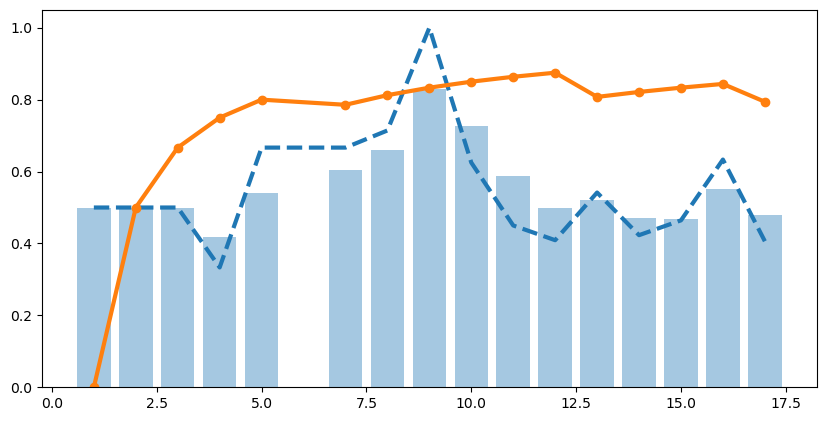

In [20]:
def multi_plot(team_name):
    team_df = year_df[year_df['team'] == gu.TEAM_NAME[team_name]]
    plt.figure(figsize=(10, 5), dpi=100)
    weeks = team_df['week']
    opp_str = team_df['team_opp_strength_after']
    opp_trn = team_df['team_opp_trn']
    trn = team_df['team_record_normal_after']

    plt.title = team_name
    plt.bar(weeks, opp_str, alpha=0.4)
    plt.plot(weeks, opp_trn, '--', lw=3)
    plt.plot(weeks, trn, '-o', lw=3)


team_name = 'Saints'
multi_plot(team_name)
trim_df(year_df[year_df['team'] == gu.TEAM_NAME[team_name]], show_fields)

,year,week,team_win,team,opponent,team_wins_after,team_losses_after,team_ties_after,team_record_normal_after,team_opp_strength_after,team_opp_trn
4121,2018,1,1,Washington Redskins,Arizona Cardinals,1,0,0,1.0,0.5,0.500000
4134,2018,2,0,Washington Redskins,Indianapolis Colts,1,1,0,0.5,0.25,0.000000
4166,2018,3,1,Washington Redskins,Green Bay Packers,2,1,0,0.666667,0.5,0.750000
4251,2018,5,0,Washington Redskins,New Orleans Saints,2,2,0,0.5,0.625,0.750000
4258,2018,6,1,Washington Redskins,Carolina Panthers,3,2,0,0.583333,0.6625,0.700000
4302,2018,7,1,Washington Redskins,Dallas Cowboys,4,2,0,0.642857,0.58125,0.500000
4321,2018,8,1,Washington Redskins,New York Giants,5,2,0,0.6875,0.362054,0.142857
4344,2018,9,0,Washington Redskins,Atlanta Falcons,5,3,0,0.611111,0.395312,0.428571
4371,2018,10,1,Washington Redskins,Tampa Bay Buccaneers,6,3,0,0.65,0.392101,0.388889
4396,2018,11,0,Washington Redskins,Houston Texans,6,4,0,0.590909,0.529384,0.666667


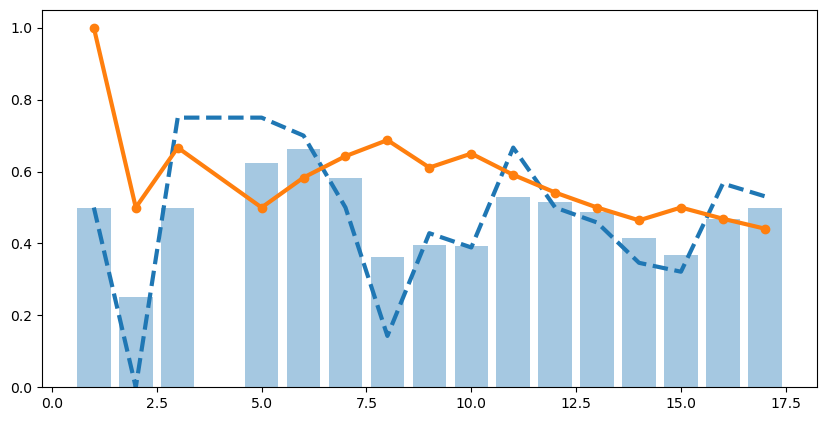

In [12]:
_TEAM_ = 'Redskins'
team_df = year_df[year_df['team'] == gu.TEAM_NAME[_TEAM_]]
multi_plot(team_df)
trim_df(team_df, show_fields)

,year,week,team_win,team,opponent,team_wins_after,team_losses_after,team_ties_after,team_record_normal_after,team_opp_strength_after,team_opp_trn
4104,2018,1,1,New England Patriots,Houston Texans,1,0,0,1.0,0.5,0.500000
4153,2018,2,0,New England Patriots,Jacksonville Jaguars,1,1,0,0.5,0.75,1.000000
4189,2018,3,0,New England Patriots,Detroit Lions,1,2,0,0.333333,0.375,0.000000
4200,2018,4,1,New England Patriots,Miami Dolphins,2,2,0,0.5,0.6875,1.000000
4222,2018,5,1,New England Patriots,Indianapolis Colts,3,2,0,0.6,0.46875,0.250000
4278,2018,6,1,New England Patriots,Kansas City Chiefs,4,2,0,0.666667,0.734375,1.000000
4289,2018,7,1,New England Patriots,Chicago Bears,5,2,0,0.714286,0.658854,0.583333
4337,2018,8,1,New England Patriots,Buffalo Bills,6,2,0,0.75,0.472284,0.285714
4360,2018,9,1,New England Patriots,Green Bay Packers,7,2,0,0.777778,0.486142,0.500000
4373,2018,10,0,New England Patriots,Tennessee Titans,7,3,0,0.7,0.493071,0.500000


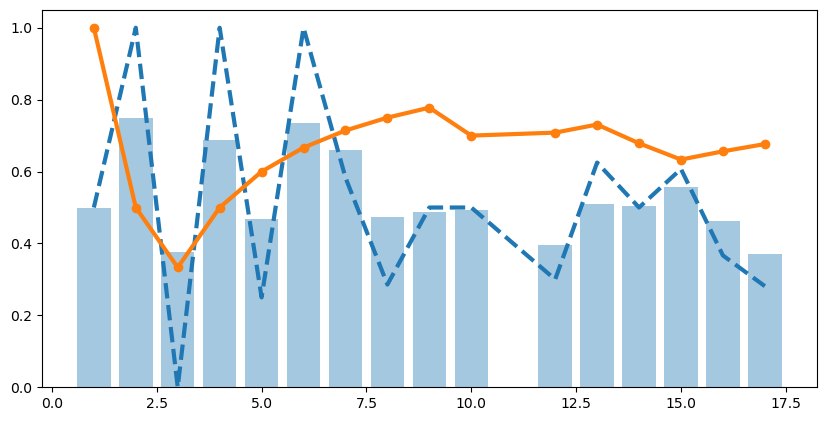

In [13]:
_TEAM_ = 'Patriots'
team_df = year_df[year_df['team'] == gu.TEAM_NAME[_TEAM_]]
multi_plot(team_df)
trim_df(team_df, show_fields)

,year,week,team_win,team,opponent,team_wins_after,team_losses_after,team_ties_after,team_record_normal_after,team_opp_strength_after,team_opp_trn
4123,2018,1,0,Chicago Bears,Green Bay Packers,0,1,0,0.0,0.5,0.500000
4158,2018,2,1,Chicago Bears,Seattle Seahawks,1,1,0,0.5,0.25,0.000000
4187,2018,3,1,Chicago Bears,Arizona Cardinals,2,1,0,0.666667,0.125,0.000000
4194,2018,4,1,Chicago Bears,Tampa Bay Buccaneers,3,1,0,0.75,0.395833,0.666667
4267,2018,6,0,Chicago Bears,Miami Dolphins,3,2,0,0.583333,0.497917,0.600000
4288,2018,7,0,Chicago Bears,New England Patriots,3,3,0,0.5,0.582292,0.666667
4314,2018,8,1,Chicago Bears,New York Jets,4,3,0,0.5625,0.505432,0.428571
4343,2018,9,1,Chicago Bears,Buffalo Bills,5,3,0,0.611111,0.377716,0.250000
4368,2018,10,1,Chicago Bears,Detroit Lions,6,3,0,0.65,0.383302,0.388889
4414,2018,11,1,Chicago Bears,Minnesota Vikings,7,3,0,0.681818,0.524984,0.666667


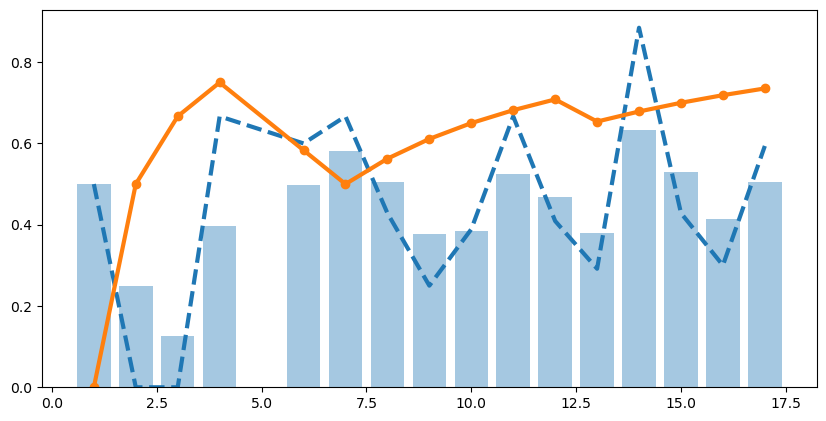

In [14]:
_TEAM_ = 'Bears'
team_df = year_df[year_df['team'] == gu.TEAM_NAME[_TEAM_]]
multi_plot(team_df)
trim_df(team_df, show_fields)

,year,week,team_win,team,opponent,team_wins_after,team_losses_after,team_ties_after,team_record_normal_after,team_opp_strength_after,team_opp_trn
4127,2018,1,1,Los Angeles Rams,Oakland Raiders,1,0,0,1.0,0.5,0.500000
4150,2018,2,1,Los Angeles Rams,Arizona Cardinals,2,0,0,1.0,0.25,0.000000
4182,2018,3,1,Los Angeles Rams,Los Angeles Chargers,3,0,0,1.0,0.375,0.500000
4192,2018,4,1,Los Angeles Rams,Minnesota Vikings,4,0,0,1.0,0.520833,0.666667
4245,2018,5,1,Los Angeles Rams,Seattle Seahawks,5,0,0,1.0,0.510417,0.500000
4273,2018,6,1,Los Angeles Rams,Denver Broncos,6,0,0,1.0,0.455208,0.400000
4305,2018,7,1,Los Angeles Rams,San Francisco 49ers,7,0,0,1.0,0.310937,0.166667
4330,2018,8,1,Los Angeles Rams,Green Bay Packers,8,0,0,1.0,0.447135,0.583333
4359,2018,9,0,Los Angeles Rams,New Orleans Saints,8,1,0,0.888889,0.629818,0.812500
4384,2018,10,1,Los Angeles Rams,Seattle Seahawks,9,1,0,0.9,0.564909,0.500000


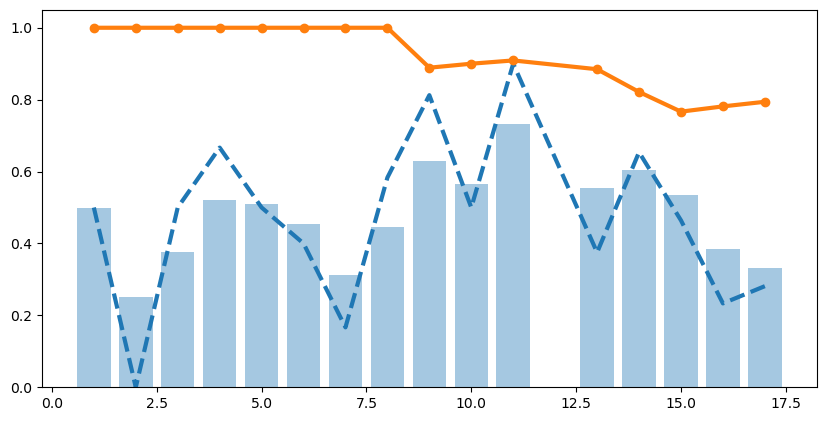

In [15]:
_TEAM_ = 'Rams'
team_df = year_df[year_df['team'] == gu.TEAM_NAME[_TEAM_]]
multi_plot(team_df)
trim_df(team_df, show_fields)

,year,week,team_win,team,opponent,team_wins_after,team_losses_after,team_ties_after,team_record_normal_after,team_opp_strength_after,team_opp_trn
4115,2018,1,1,Kansas City Chiefs,Los Angeles Chargers,1,0,0,1.0,0.5,0.500000
4139,2018,2,1,Kansas City Chiefs,Pittsburgh Steelers,2,0,0,1.0,0.75,1.000000
4176,2018,3,1,Kansas City Chiefs,San Francisco 49ers,3,0,0,1.0,0.625,0.500000
4221,2018,4,1,Kansas City Chiefs,Denver Broncos,4,0,0,1.0,0.645833,0.666667
4232,2018,5,1,Kansas City Chiefs,Jacksonville Jaguars,5,0,0,1.0,0.697917,0.750000
4279,2018,6,0,Kansas City Chiefs,New England Patriots,5,1,0,0.833333,0.648958,0.600000
4306,2018,7,1,Kansas City Chiefs,Cincinnati Bengals,6,1,0,0.857143,0.657812,0.666667
4322,2018,8,1,Kansas City Chiefs,Denver Broncos,7,1,0,0.875,0.543192,0.428571
4353,2018,9,1,Kansas City Chiefs,Cleveland Browns,8,1,0,0.888889,0.427846,0.312500
4376,2018,10,1,Kansas City Chiefs,Arizona Cardinals,9,1,0,0.9,0.338923,0.250000


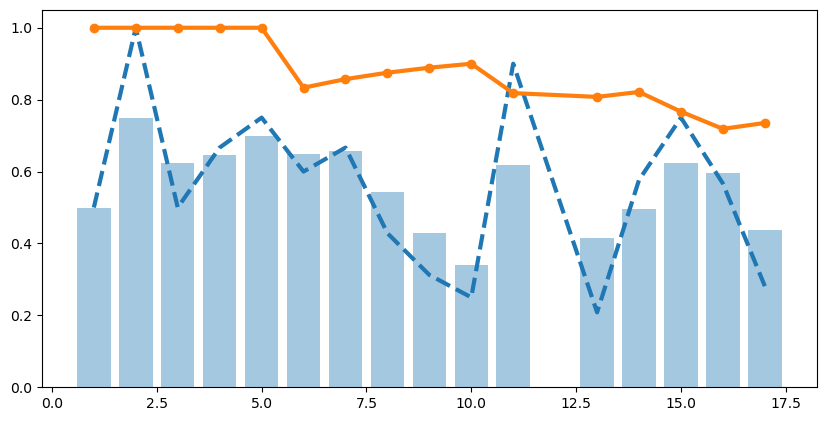

In [16]:
_TEAM_ = 'Chiefs'
team_df = year_df[year_df['team'] == gu.TEAM_NAME[_TEAM_]]
multi_plot(team_df)
trim_df(team_df, show_fields)